<a href="https://colab.research.google.com/github/Sadamingh/MSDS601_Final_Project/blob/main/draft_ap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import copy
from math import *

import pandas as pd
import numpy as np
import scipy
from scipy import stats
from scipy.stats import kstest
from scipy.stats import boxcox
import scipy.linalg as linalg

from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Sadamingh/MSDS601_Final_Project/main/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1. Check Multicollinearity

In [ ]:
y, X = dmatrices('charges ~ age + bmi + children + sex + smoker + region', data=df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif["Multicollinearity"] = vif["VIF Factor"] >= 10
vif

,VIF Factor,features,Multicollinearity
0,35.527488,Intercept,True
1,1.008900,sex[T.male],False
2,1.012074,smoker[T.yes],False
3,1.518823,region[T.northwest],False
4,1.652230,region[T.southeast],False
5,1.529411,region[T.southwest],False
6,1.016822,age,False
7,1.106630,bmi,False
8,1.004011,children,False


## 2.  Fit in the model

In [ ]:
model = smf.ols('charges ~ age + bmi + children + sex + smoker + region', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:48:42   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.194e+04    987.819    -12.086      0.000   -1.39e+04      -1e+04
sex[T.male]          -131.3144    332.945     -0.394      0.693    -784.470     521.842
smoker[T.yes]        2.385e+04    413.153     57.723      0.000     2.3e+04    2.47e+04
region[T.northwest]  -352.9639    476.276     -0.741      0.459   -1287.298     581.370
region[T.southeast] -1035.0220    478.692     -2.162      0.031   -1974.097     -95.947
region[T.southwest]  -960.0510    477.933     -2.009      0.045   -1897.636     -22.466
age                   256.8564     11.899     21.587      0.000     233.514     280.199
bmi                   339.1935     28.599     11.860      0.000     283.088     395.298
children              475.5005    137.804      3.451      0.001     205.163     745.838
==============================================================================
Omnibus:                      300.366   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.887
Skew:                           1.211   Prob(JB):                    7.86e-157
Kurtosis:                       5.651   Cond. No.                         311.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. Check Influential Points

### (1) Check Externally Studentized Residuals

In [ ]:
infl = model.get_influence()
ex_studti = infl.resid_studentized_external

n = len(ex_studti)
k = model.df_model + 1

seuil_stud = scipy.stats.t.ppf(0.975, df=n-k-1)
atyp_stud = np.abs(ex_studti) >= seuil_stud

ex_studenti = pd.DataFrame()
ex_studenti['Index of Position'] = df.index[atyp_stud]
ex_studenti['External Studendized Residual'] = ex_studti[atyp_stud]
ex_studenti['Original Residuals'] = list(model.resid[atyp_stud])
ex_studenti.head()

,Index of Position,External Studendized Residual,Original Residuals
0,3,3.025106,18229.640447
1,9,2.827391,17038.499402
2,34,3.385694,20361.808397
3,62,2.871484,17297.049593
4,102,3.062004,18445.160075


### (2) Check Cook's Distance

In [ ]:
infl = model.get_influence()
inflsum = infl.summary_frame()

reg_cook = inflsum.cooks_d
atyp_cook = np.abs(reg_cook) >= 4/n

cooki = pd.DataFrame()
cooki['Index of Position'] = df.index[atyp_cook]
cooki['Cook\'s Distance'] = list(reg_cook[atyp_cook])
cooki.head()

,Index of Position,Cook's Distance
0,3,0.005871
1,9,0.005871
2,34,0.010236
3,62,0.006641
4,69,0.002991


### (3) Delete data points selected from both of these methods

In [ ]:
df_droppoints = df
influencial_points = set(ex_studenti['Index of Position']).union(set(cooki['Index of Position']))

for i in influencial_points:
    df_droppoints = df_droppoints.drop(index=i, axis =1)
    
df_droppoints.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620
4,32,male,28.88,0,no,northwest,3866.8552
5,31,female,25.74,0,no,southeast,3756.6216


## 4. Check Heteroscedasticity

In [ ]:
# fit in the new model
model_droppoints = smf.ols('charges ~ age + bmi + children + sex + smoker + region', data=df_droppoints).fit()
model_droppoints.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     971.9
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:50:59   Log-Likelihood:                -12091.
No. Observations:                1237   AIC:                         2.420e+04
Df Residuals:                    1228   BIC:                         2.425e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.103e+04    737.327    -14.961      0.000   -1.25e+04   -9584.896
sex[T.male]           -96.4388    244.242     -0.395      0.693    -575.616     382.739
smoker[T.yes]          2.5e+04    309.654     80.741      0.000    2.44e+04    2.56e+04
region[T.northwest]  -949.8945    350.953     -2.707      0.007   -1638.428    -261.361
region[T.southeast]  -976.3730    352.469     -2.770      0.006   -1667.881    -284.865
region[T.southwest]  -919.4873    349.349     -2.632      0.009   -1604.875    -234.100
age                   253.1093      8.716     29.038      0.000     236.009     270.210
bmi                   282.3776     21.518     13.123      0.000     240.162     324.593
children              505.9924    101.315      4.994      0.000     307.223     704.762
==============================================================================
Omnibus:                       35.135   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.649
Skew:                          -0.207   Prob(JB):                     2.49e-14
Kurtosis:                       4.022   Cond. No.                         318.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### (1) Residual vs. Fitted Value Plot

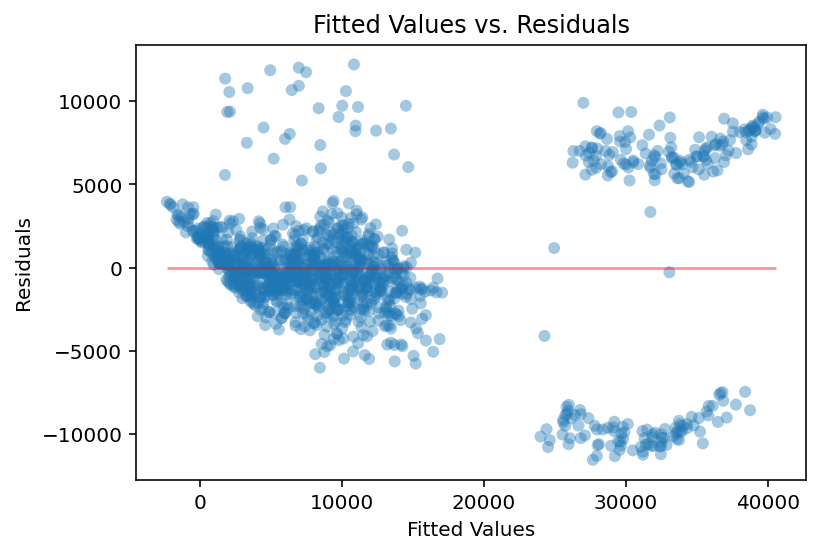

In [ ]:
fittedvals = model_droppoints.fittedvalues
residuals = model_droppoints.resid

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(fittedvals, residuals, alpha=0.4, edgecolors='none')
ax.hlines(0, xmin=min(fittedvals), xmax=max(fittedvals), colors='r', alpha=0.4)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs. Residuals")
plt.show()

### (2) Breush-Pagan test

In [ ]:
bp_test = het_breuschpagan(model_droppoints.resid, model_droppoints.model.exog)
labels = ['BP Statistic', 'BP-Test p-value']
bp_result = dict(zip(labels, bp_test))
if bp_result['BP-Test p-value'] < 0.05:
    print('Reject H0, there’s a significant heteroscedasticity problem at the 95% confidence level.')
else:
    print('Can\'t reject H0, there’s no significant heteroscedasticity problem at the 95% confidence level.')

Reject H0, there’s a significant heteroscedasticity problem at the 95% confidence level.


### (3) Log Transformation

In [ ]:
charges = df_droppoints['charges']
charges_max = max(charges) + 1e-10
charges_log = [log(charges_max - i) for i in charges] 
model_log = smf.ols('charges_log ~ age + bmi + children + sex + smoker + region', data=df_droppoints).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            charges_log   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     52.75
Date:                Sun, 29 Nov 2020   Prob (F-statistic):           1.12e-73
Time:                        14:56:59   Log-Likelihood:                -1719.0
No. Observations:                1237   AIC:                             3456.
Df Residuals:                    1228   BIC:                             3502.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              11.8492      0.168     70.400      0.000      11.519      12.179
sex[T.male]            -0.0500      0.056     -0.897      0.370      -0.159       0.059
smoker[T.yes]          -1.2844      0.071    -18.171      0.000      -1.423      -1.146
region[T.northwest]     0.0379      0.080      0.473      0.637      -0.119       0.195
region[T.southeast]    -0.0518      0.080     -0.643      0.520      -0.210       0.106
region[T.southwest]     0.0328      0.080      0.412      0.681      -0.124       0.189
age                    -0.0132      0.002     -6.622      0.000      -0.017      -0.009
bmi                    -0.0205      0.005     -4.166      0.000      -0.030      -0.011
children               -0.0351      0.023     -1.519      0.129      -0.081       0.010
==============================================================================
Omnibus:                     3230.049   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         44441752.714
Skew:                         -28.429   Prob(JB):                         0.00
Kurtosis:                     929.831   Cond. No.                         318.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

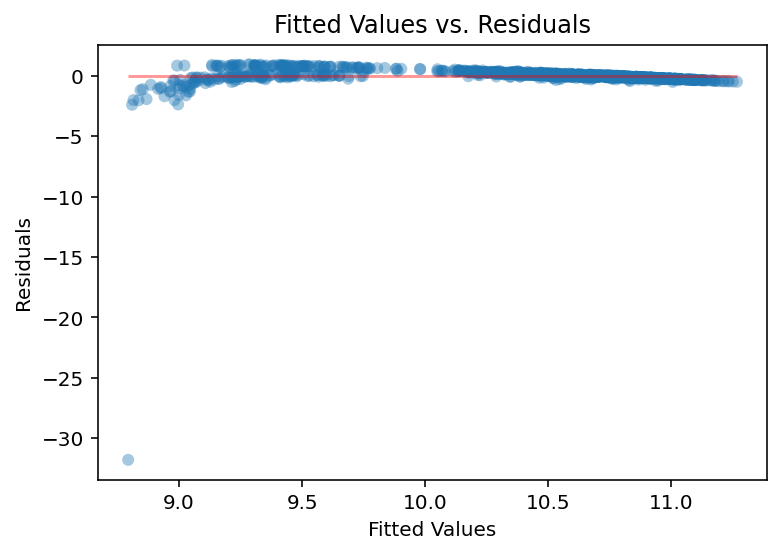

In [ ]:
fittedvals = model_log.fittedvalues
residuals = model_log.resid

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(fittedvals, residuals, alpha=0.4, edgecolors='none')
ax.hlines(0, xmin=min(fittedvals), xmax=max(fittedvals), colors='r', alpha=0.4)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs. Residuals")
plt.show()

In [ ]:
bp_test = het_breuschpagan(model_log.resid, model_log.model.exog)
labels = ['BP Statistic', 'BP-Test p-value']
bp_result = dict(zip(labels, bp_test))
if bp_result['BP-Test p-value'] < 0.05:
    print('Reject H0, there’s a significant heteroscedasticity problem at the 95% confidence level.')
else:
    print('Can\'t reject H0, there’s no significant heteroscedasticity problem at the 95% confidence level.')

Can't reject H0, there’s no significant heteroscedasticity problem at the 95% confidence level.


### (4) Drop the New Influential Points

In [ ]:
df_droppoints['logcharges'] = charges_log

In [ ]:
infl = model_log.get_influence()
ex_studti = infl.resid_studentized_external

n = len(ex_studti)
k = model_log.df_model + 1

seuil_stud = scipy.stats.t.ppf(0.975, df=n-k-1)
atyp_stud = np.abs(ex_studti) >= seuil_stud

ex_studenti = pd.DataFrame()
ex_studenti['Index of Position'] = df_droppoints.index[atyp_stud]
ex_studenti['External Studendized Residual'] = ex_studti[atyp_stud]
ex_studenti['Original Residuals'] = list(model_log.resid[atyp_stud])
ex_studenti

,Index of Position,External Studendized Residual,Original Residuals
0,175,-2.453176,-2.371725
1,281,-1.997374,-1.931932
2,330,-2.081829,-2.015255
3,530,-2.074667,-2.009964
4,901,-2.094377,-2.028163
5,1062,-2.478469,-2.399432
6,1241,-92.847701,-31.800547


In [ ]:
infl = model_log.get_influence()
inflsum = infl.summary_frame()

reg_cook = inflsum.cooks_d
atyp_cook = np.abs(reg_cook) >= 4/n

cooki = pd.DataFrame()
cooki['Index of Position'] = df_droppoints.index[atyp_cook]
cooki['Cook\'s Distance'] = list(reg_cook[atyp_cook])
cooki

,Index of Position,Cook's Distance
0,39,0.004029
1,175,0.008111
2,281,0.005717
3,328,0.003334
4,330,0.005285
5,530,0.004472
6,901,0.004958
7,1062,0.006344
8,1241,1.170899


In [ ]:
df_log = df_droppoints
influencial_points = set(ex_studenti['Index of Position']).union(set(cooki['Index of Position']))

for i in influencial_points:
    df_log = df_log.drop(index=i, axis=1)
    
df_log.head()

,age,sex,bmi,children,smoker,region,charges,logcharges
0,19,female,27.90,0,yes,southwest,16884.9240,10.394908
1,18,male,33.77,1,no,southeast,1725.5523,10.775870
2,28,male,33.00,3,no,southeast,4449.4620,10.717263
4,32,male,28.88,0,no,northwest,3866.8552,10.730090
5,31,female,25.74,0,no,southeast,3756.6216,10.732499


### (5) Again, fit in the model

In [ ]:
model_log = smf.ols('logcharges ~ age + bmi + children + sex + smoker + region', data=df_log).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logcharges   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     367.4
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          2.08e-318
Time:                        15:18:24   Log-Likelihood:                -218.91
No. Observations:                1228   AIC:                             455.8
Df Residuals:                    1219   BIC:                             501.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              11.4754      0.051    226.719      0.000      11.376      11.575
sex[T.male]            -0.0060      0.017     -0.358      0.721      -0.039       0.027
smoker[T.yes]          -1.0808      0.021    -50.553      0.000      -1.123      -1.039
region[T.northwest]     0.0263      0.024      1.101      0.271      -0.021       0.073
region[T.southeast]     0.0251      0.024      1.044      0.297      -0.022       0.072
region[T.southwest]     0.0374      0.024      1.569      0.117      -0.009       0.084
age                    -0.0084      0.001    -14.073      0.000      -0.010      -0.007
bmi                    -0.0161      0.001    -10.956      0.000      -0.019      -0.013
children               -0.0232      0.007     -3.366      0.001      -0.037      -0.010
==============================================================================
Omnibus:                      452.375   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4429.184
Skew:                          -1.418   Prob(JB):                         0.00
Kurtosis:                      11.861   Cond. No.                         319.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

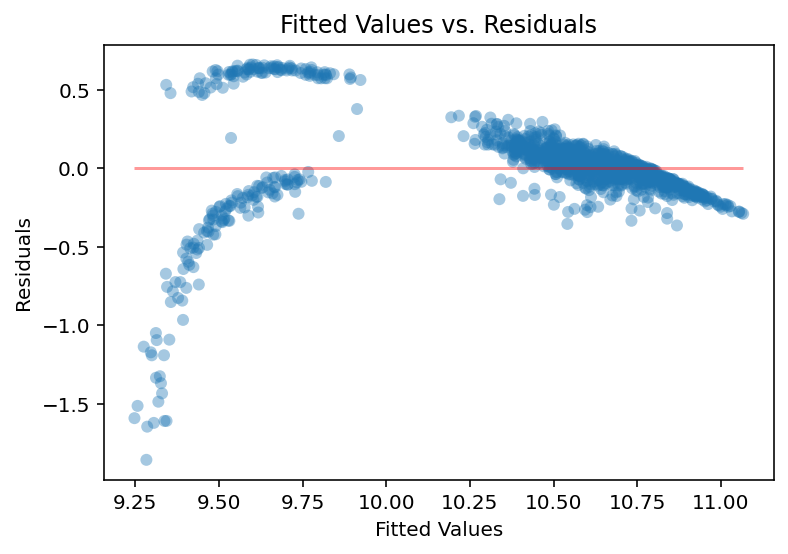

In [ ]:
fittedvals = model_log.fittedvalues
residuals = model_log.resid

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(fittedvals, residuals, alpha=0.4, edgecolors='none')
ax.hlines(0, xmin=min(fittedvals), xmax=max(fittedvals), colors='r', alpha=0.4)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs. Residuals")
plt.show()

In [ ]:
bp_test = het_breuschpagan(model_log.resid, model_log.model.exog)
labels = ['BP Statistic', 'BP-Test p-value']
bp_result = dict(zip(labels, bp_test))
if bp_result['BP-Test p-value'] < 0.05:
    print('Reject H0, there’s a significant heteroscedasticity problem at the 95% confidence level.')
else:
    print('Can\'t reject H0, there’s no significant heteroscedasticity problem at the 95% confidence level.')

Reject H0, there’s a significant heteroscedasticity problem at the 95% confidence level.


## 5. Check Normality

### (1) Histogram Plot

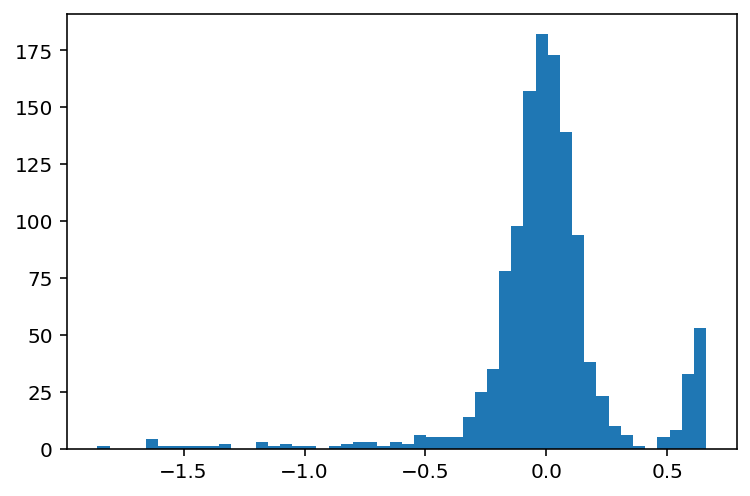

In [ ]:
s = stats.skew(model_log.resid)
k = stats.kurtosis(model_log.resid)
plt.hist(model_log.resid, bins=50)
plt.show()

### (2) QQ Plot

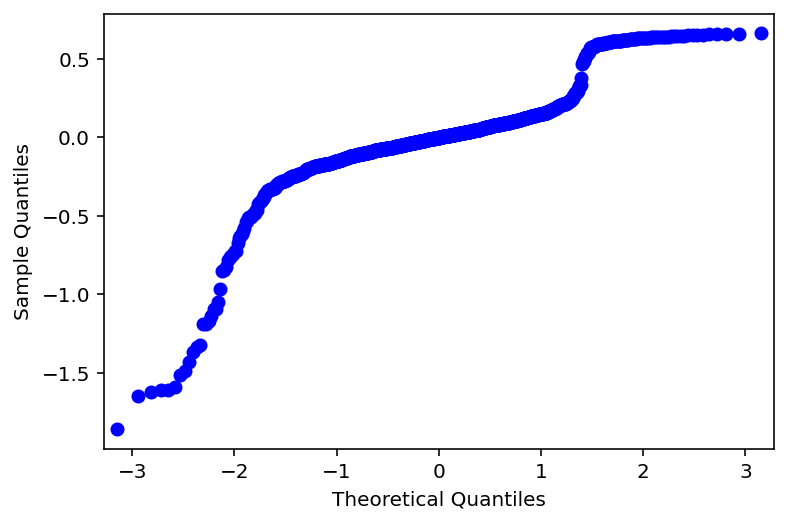

In [ ]:
fig = sm.qqplot(model_log.resid)

### (3) K-Square Test

In [ ]:
KstestResult = kstest(model_log.resid,'norm')
if KstestResult[1] < 0.05:
    print('Reject H0, the model is not normality at 95% confidence level.')
else:
    print('Can\'t reject H0, the model is normality at 95% confidence level.')

Reject H0, the model is not normality at 95% confidence level.


### (4) JB Test

In [ ]:
if stats.jarque_bera(model_log.resid)[1] < 0.05:
    print('Reject H0, the model is not normality at 95% confidence level.')
else:
    print('Can\'t reject H0, the model is normality at 95% confidence level.')

Reject H0, the model is not normality at 95% confidence level.


### (5) Box-Cox Transformation

In [ ]:
fitted_charges, fitted_lambda = boxcox(df_log['logcharges'])
df_boxcox = df_log
df_boxcox['fitted_charges'] = fitted_charges
model_boxcox = smf.ols('fitted_charges ~ age + bmi + children + sex + smoker + region', data=df_boxcox).fit()
model_boxcox.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         fitted_charges   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     1311.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:12:54   Log-Likelihood:                -71110.
No. Observations:                1228   AIC:                         1.422e+05
Df Residuals:                    1219   BIC:                         1.423e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            4.526e+25   5.96e+23     75.909      0.000    4.41e+25    4.64e+25
sex[T.male]          4.743e+23   1.96e+23      2.417      0.016    8.93e+22    8.59e+23
smoker[T.yes]       -2.261e+25   2.52e+23    -89.758      0.000   -2.31e+25   -2.21e+25
region[T.northwest]  1.098e+24   2.82e+23      3.901      0.000    5.46e+23    1.65e+24
region[T.southeast]   1.34e+24   2.84e+23      4.724      0.000    7.83e+23     1.9e+24
region[T.southwest]  1.085e+24   2.81e+23      3.861      0.000    5.33e+23    1.64e+24
age                 -3.401e+23   7.04e+21    -48.337      0.000   -3.54e+23   -3.26e+23
bmi                 -1.746e+23   1.73e+22    -10.086      0.000   -2.09e+23   -1.41e+23
children            -6.334e+23   8.13e+22     -7.788      0.000   -7.93e+23   -4.74e+23
==============================================================================
Omnibus:                      461.734   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2062.225
Skew:                          -1.737   Prob(JB):                         0.00
Kurtosis:                       8.314   Cond. No.                         319.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

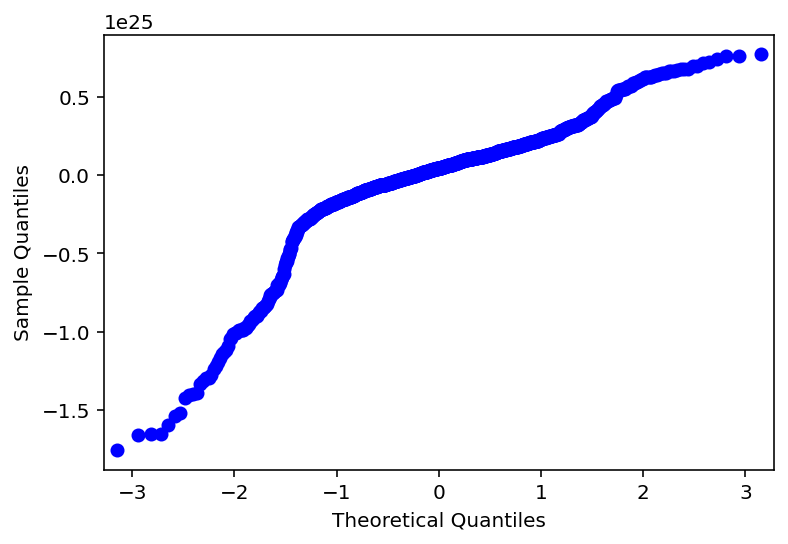

In [ ]:
fig = sm.qqplot(model_boxcox.resid)

## 6. Check Linearity

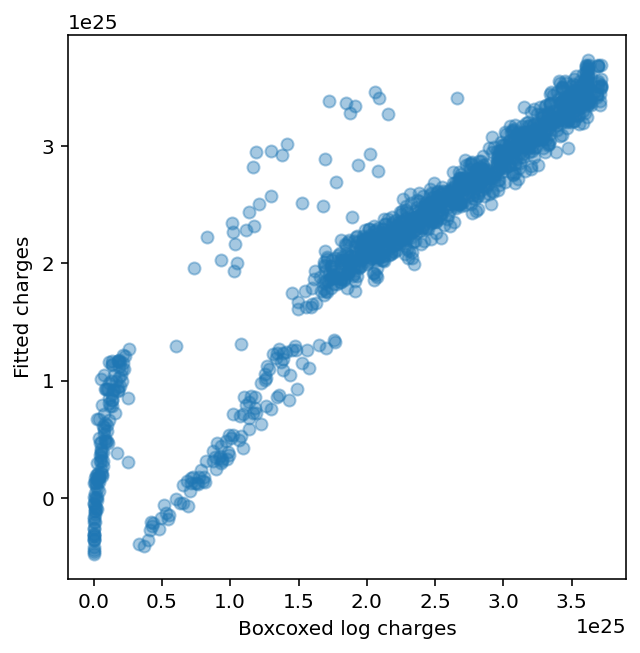

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(fitted_charges, model_boxcox.predict(), alpha=.4)
ax.set_xlabel('Boxcoxed log charges')
ax.set_ylabel('Fitted charges')
plt.show()

In [ ]:
df_boxcox.head()

,age,sex,bmi,children,smoker,region,charges,logcharges,fitted_charges
0,19,female,27.90,0,yes,southwest,16884.9240,10.394908,1.406611e+25
1,18,male,33.77,1,no,southeast,1725.5523,10.775870,3.602173e+25
2,28,male,33.00,3,no,southeast,4449.4620,10.717263,3.123819e+25
4,32,male,28.88,0,no,northwest,3866.8552,10.730090,3.222983e+25
5,31,female,25.74,0,no,southeast,3756.6216,10.732499,3.241938e+25


In [ ]:
df_boxcox.drop(['charges','logcharges'],axis=1,inplace=True)
df_boxcox.head()

,age,sex,bmi,children,smoker,region,fitted_charges
0,19,female,27.90,0,yes,southwest,1.406611e+25
1,18,male,33.77,1,no,southeast,3.602173e+25
2,28,male,33.00,3,no,southeast,3.123819e+25
4,32,male,28.88,0,no,northwest,3.222983e+25
5,31,female,25.74,0,no,southeast,3.241938e+25


## 7. Model Selection

### (1) Forward Selection

In [ ]:
def ForwardSelection(df, keyword, method):
    '''
    The df input is the our dataframe for model selection.
    The keyword input is the name of the dependent variable.
    The method input is the measure for model selection:
    - AIC: 'aic'
    - BIC: 'bic'
    - Adjusted R Square: 'R_sq_adj'
    - Mallows's Cp: 'cp'
    The output of this model is a plot of the method value by
    the number of the predictors we choose.
    This function returns the final model by forward selection.
    '''
    selection = pd.DataFrame()
    predictors = list(df.keys())
    predictors.remove(keyword)
    
    subsets = [[]]
    
    for predictor in predictors:
        prev = copy.deepcopy(subsets)
        [k.append(predictor) for k in subsets]
        subsets.extend(prev)
    
    predstr = [' + '.join(i) for i in subsets if i]
    
    model_full = smf.ols(f'{keyword} ~ {predstr[0]}', data=df).fit()
    n = len(df)
    k = len(df.keys())
    MSE_full = sum(model_full.resid**2)/(n-k)
    
    measure_values = []
    step_values = []
    
    for predictor in predictors:
        modelstr = keyword + ' ~ ' + predictor
        model = smf.ols(f'{modelstr}', data=df).fit()
        
        if method == 'aic':
            measure_values.append(model.aic)
        elif method == 'bic':
            measure_values.append(model.bic)
        elif method == 'R_sq_adj':
            measure_values.append(model.rsquared_adj)
        elif method == 'cp':
            p = 2
            cp = sum(model.resid**2)/MSE_full - (n - 2*p)
            measure_values.append(cp)
    
    step_values.append(max(measure_values))
    best = predictors[measure_values.index(max(measure_values))]
    predictors.remove(best)
    keyword = keyword + ' ~ ' + best
    
    while predictors:
        
        measure_values = []
        
        for predictor in predictors:
            modelstr = keyword + ' + ' + predictor
            model = smf.ols(f'{modelstr}', data=df).fit()

            if method == 'aic':
                measure_values.append(model.aic)
            elif method == 'bic':
                measure_values.append(model.bic)
            elif method == 'R_sq_adj':
                measure_values.append(model.rsquared_adj)
            elif method == 'cp':
                p = len(modelstr.split(' + ')) + 1
                cp = sum(model.resid**2)/MSE_full - (n - 2*p)
                measure_values.append(cp)
        
        step_values.append(max(measure_values))
        best = predictors[measure_values.index(max(measure_values))]
        predictors.remove(best)
        keyword = keyword + ' + ' + best
        
    fig, ax = plt.subplots(figsize=(3,3))
    
    ax.plot(range(1, len(keyword.split(' + ')) + 1), step_values)
    ax.set_xlabel('Number of the predictors')
    ax.set_ylabel(method)

    plt.show()
    
    if method == 'R_sq_adj':
        best_model = ' + '.join(keyword.split(' + ')[:step_values.index(max(step_values))+1])
    else:
        best_model = ' + '.join(keyword.split(' + ')[:step_values.index(min(step_values))+1])
    
    return best_model

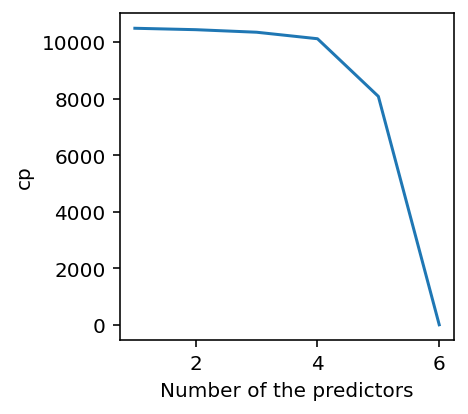

'fitted_charges ~ sex + region + children + bmi + age + smoker'

In [ ]:
ForwardSelection(df_boxcox, 'fitted_charges', 'cp')

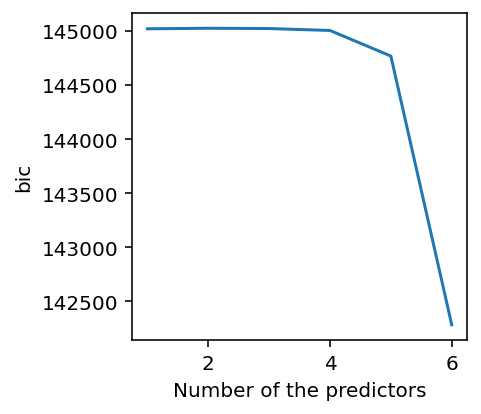

'fitted_charges ~ region + sex + children + bmi + age + smoker'

In [ ]:
ForwardSelection(df_boxcox, 'fitted_charges', 'bic')

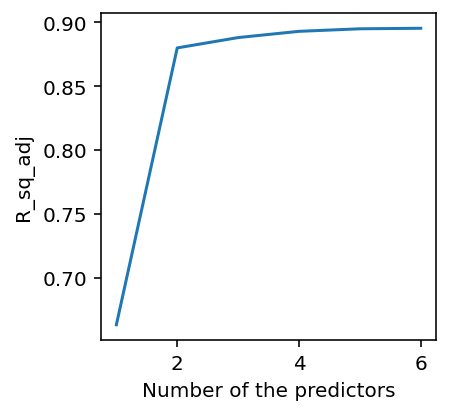

'fitted_charges ~ smoker + age + bmi + children + region + sex'

In [ ]:
ForwardSelection(df_boxcox, 'fitted_charges', 'R_sq_adj')

### (2) Subset Selection

In [ ]:
def SubsetSelection(df, keyword):
    '''
    This is a function for the subset model selection. The
    output of this function is a dataframe with the stats 
    of every subset. 
    The input df is our input dataframe, and the input keyword
    is the name of the dependent variable.
    '''
    selection = pd.DataFrame()
    predictors = list(df.keys())
    predictors.remove(keyword)
    subsets = [[]]
    
    for predictor in predictors:
        prev = copy.deepcopy(subsets)
        [k.append(predictor) for k in subsets]
        subsets.extend(prev)
    
    predstr = [' + '.join(i) for i in subsets if i]
    varnum = [len(i) for i in subsets if i]
    
    model_full = smf.ols(f'{keyword} ~ {predstr[0]}', data=df).fit()
    n = len(df)
    k = len(df.keys())
    MSE_full = sum(model_full.resid**2)/(n-k)
    
    r2 = []
    adjr2 = []
    aic = []
    bic = []
    cplist = []
    for stritem in predstr:
        model = smf.ols(f'{keyword} ~ {stritem}', data=df).fit()
        
        r2.append(model.rsquared)
        adjr2.append(model.rsquared_adj)
        aic.append(model.aic)
        bic.append(model.bic)
        
        p = len(stritem.split(' + ')) + 1
        cp = sum(model.resid**2)/MSE_full - (n - 2*p)
        cplist.append(cp)
    
    selection['Vars'] = varnum
    selection['R-Sq'] = r2
    selection['Adj R-Sq'] = adjr2
    selection['AIC'] = aic
    selection['BIC'] = bic
    selection['Mallows\'s Cp'] = cplist
    selection['Predictors'] = predstr
    
    selection = selection.sort_values(by=['Vars'], ascending=True)
    
    return selection

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
SubsetSelection(df_boxcox, 'fitted_charges').head(63)

,Vars,R-Sq,Adj R-Sq,AIC,BIC,Mallows's Cp,Predictors
31,1,0.004545,0.002105,144999.524791,145019.977359,10450.503056,region
59,1,0.022528,0.021730,144973.138108,144983.364393,10239.602782,bmi
55,1,0.007542,0.006733,144991.821342,145002.047626,10415.347688,children
47,1,0.663561,0.663287,143663.409632,143673.635917,2721.686304,smoker
61,1,0.001910,0.001096,144998.771306,145008.997590,10481.408269,sex
62,1,0.186378,0.185715,144747.831757,144758.058041,8317.997195,age
43,2,0.682171,0.681652,143595.535050,143610.874477,2505.440412,bmi + smoker
29,2,0.006354,0.003104,144999.291217,145024.856928,10431.287941,sex + region
30,2,0.192048,0.189406,144745.244080,144770.809791,8253.500671,age + region
23,2,0.012575,0.009346,144991.578267,145017.143978,10358.324138,children + region


### (3) Final Model

In [ ]:
model_final = smf.ols('fitted_charges ~ smoker + age + bmi + children + region + sex', data=df_boxcox).fit()
model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         fitted_charges   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     1311.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:10:16   Log-Likelihood:                -71110.
No. Observations:                1228   AIC:                         1.422e+05
Df Residuals:                    1219   BIC:                         1.423e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            4.526e+25   5.96e+23     75.909      0.000    4.41e+25    4.64e+25
smoker[T.yes]       -2.261e+25   2.52e+23    -89.758      0.000   -2.31e+25   -2.21e+25
region[T.northwest]  1.098e+24   2.82e+23      3.901      0.000    5.46e+23    1.65e+24
region[T.southeast]   1.34e+24   2.84e+23      4.724      0.000    7.83e+23     1.9e+24
region[T.southwest]  1.085e+24   2.81e+23      3.861      0.000    5.33e+23    1.64e+24
sex[T.male]          4.743e+23   1.96e+23      2.417      0.016    8.93e+22    8.59e+23
age                 -3.401e+23   7.04e+21    -48.337      0.000   -3.54e+23   -3.26e+23
bmi                 -1.746e+23   1.73e+22    -10.086      0.000   -2.09e+23   -1.41e+23
children            -6.334e+23   8.13e+22     -7.788      0.000   -7.93e+23   -4.74e+23
==============================================================================
Omnibus:                      461.734   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2062.225
Skew:                          -1.737   Prob(JB):                         0.00
Kurtosis:                       8.314   Cond. No.                         319.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""